# Bibliotecas

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay, brier_score_loss
)
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
import optuna
from functools import partial

# Extração dos dados

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/My Drive/xG/"

X_train = pd.read_csv(path + "X_train_.csv")
X_test  = pd.read_csv(path + "X_test_.csv")
y_train = pd.read_csv(path + "y_train.csv")
y_test  = pd.read_csv(path + "y_test.csv")
xg = pd.read_csv(path + 'X_baseline.csv')
xg_baseline = xg.loc[X_test.index]
xg_baseline = xg_baseline['shot_statsbomb_xg'].values

# Funções auxiliares

In [ ]:
def result(X_test, model):

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    brier = brier_score_loss(y_test, y_prob)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nBrier Score: ", round(brier, 4))

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title("Curva ROC")
    plt.show()

    plt.figure(figsize=(10,5))
    sns.histplot(y_prob, color='blue', kde=True, stat='density', label='MLP (xG)')
    sns.histplot(xg_baseline, color='red', kde=True, stat='density', label='StatsBomb (xG)')
    plt.title("Distribuição das Probabilidades (Teste)")
    plt.xlabel("xG Predito")
    plt.legend()
    plt.show()

    plt.hist(y_prob, bins=100)
    plt.show()

    print("Min", np.min(y_prob))
    print("Max", np.max(y_prob))
    print("Mean", np.mean(y_prob))

In [ ]:
def objective(trial, metric: str = "accuracy", pca_method: bool = False):

    # Hiperparâmetros que o Optuna vai testar
    hidden_layers = trial.suggest_int("num_layers", 1, 4)
    layer_sizes = tuple([
        trial.suggest_int(f"layer_{i}_size", 16, 512)
        for i in range(hidden_layers)
    ])

    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    solver = trial.suggest_categorical("solver", ["adam", "sgd"])

    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)

    batch_size = trial.suggest_int("batch_size", 32, 512)

    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)

    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "adaptive", "invscaling"])

    max_iter = trial.suggest_int("max_iter", 200, 1000)

    # Parâmetros específicos do SGD
    if solver == "sgd":
        momentum = trial.suggest_float("momentum", 0.0, 0.99)
        nesterov = trial.suggest_categorical("nesterovs_momentum", [True, False])
    else:
        momentum = 0.9
        nesterov = False

    # Criar o modelo
    model = MLPClassifier(
        hidden_layer_sizes=layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        batch_size=batch_size,
        learning_rate_init=learning_rate_init,
        learning_rate=learning_rate,
        momentum=momentum,
        nesterovs_momentum=nesterov,
        max_iter=max_iter,
        random_state=42,
        early_stopping=True
    )

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", model)
    ])

    metric_value = 0

    if(pca_method):

        # Normalização dos dados
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Definir o número de componentes a ser testado pelo Optuna
        n_components = trial.suggest_int('n_components', 1, X_train_scaled.shape[1])

        # Aplicar PCA
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Treina
        pipeline.fit(X_train_pca, y_train.values.ravel())

        y_pred = pipeline.predict(X_test_pca)
        y_prob = pipeline.predict_proba(X_test_pca)[:, 1]

        match metric:
            case "accuracy":
                metric_value = accuracy_score(y_test, y_pred)
            case "auc":
                metric_value = roc_auc_score(y_test, y_prob)
            case "recall":
                metric_value = recall_score(y_test, y_pred)
            case "brier_score":
                metric_value = brier_score_loss(y_test, y_prob)

    else:
        # Treina
        pipeline.fit(X_train, y_train.values.ravel())

        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]

        match metric:
            case "accuracy":
                metric_value = accuracy_score(y_test, y_pred)
            case "auc":
                metric_value = roc_auc_score(y_test, y_prob)
            case "recall":
                metric_value = recall_score(y_test, y_pred)
            case "brier_score":
                metric_value = brier_score_loss(y_test, y_prob)

    return metric_value

In [ ]:
def run_mlp_multiple_times(
    X_train, y_train, X_test, y_test,
    mlp_params,
    n_runs=30
):
    all_probs = []        # probabilidades por instância
    brier_scores = []
    accuracies = []
    aucs = []

    for seed in range(n_runs):
        model = MLPClassifier(
            **mlp_params,
            random_state=seed
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # armazenar
        all_probs.append(y_prob)
        brier_scores.append(brier_score_loss(y_test, y_prob))
        accuracies.append(accuracy_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_prob))

    return {
        "all_probs": np.array(all_probs),  # shape: (30, n_samples)
        "brier": np.array(brier_scores),
        "accuracy": np.array(accuracies),
        "auc": np.array(aucs)
    }

# Treinamento 1 - Modelo Base

In [ ]:
mlp = MLPClassifier()

mlp.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.64      0.28      0.38       167

    accuracy                           0.91      1567
   macro avg       0.78      0.63      0.67      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0742


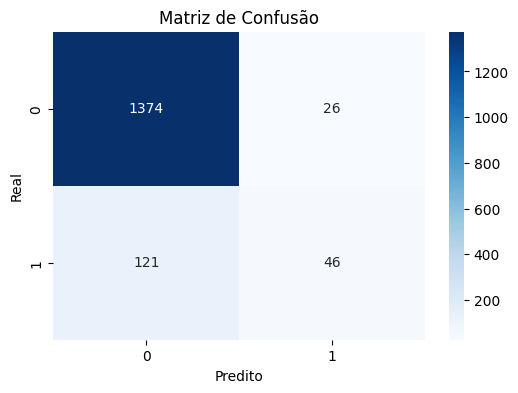

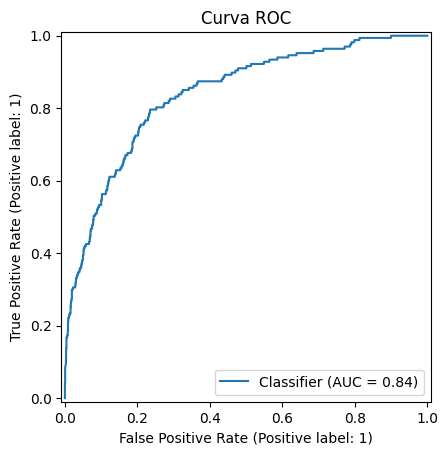

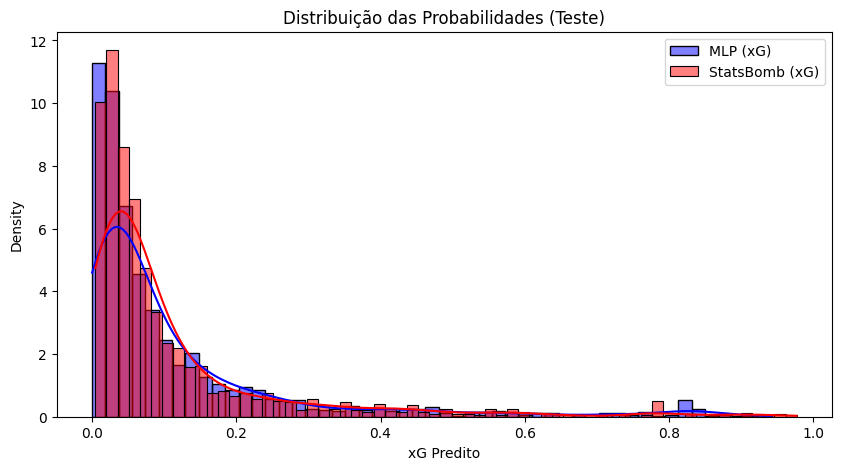

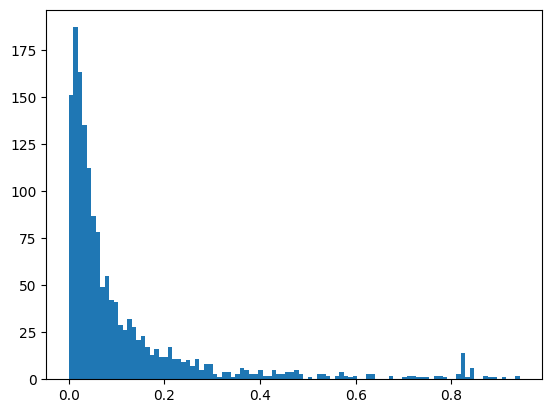

Min 1.2744993058334141e-05
Max 0.9426718283591534
Mean 0.11400558994240487


In [ ]:
results(X_test, mlp)

# Treinamento 2 - Modelo Base + PCA

## PCA

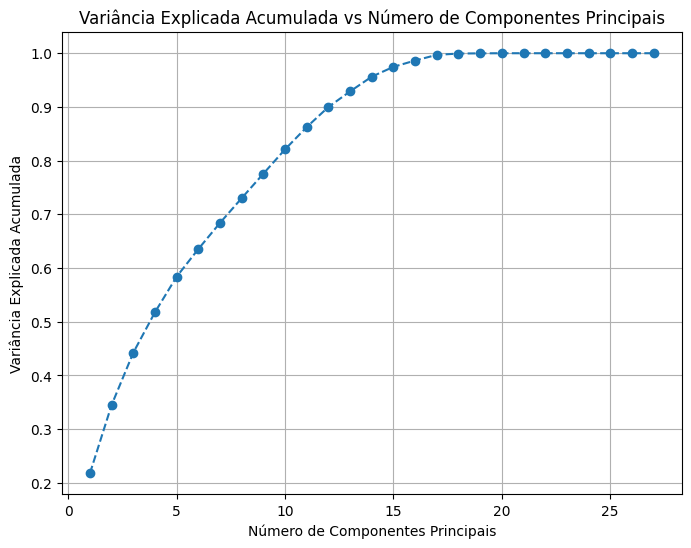

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar o PCA
pca = PCA()
pca.fit(X_train_scaled)

# Plotar a variância explicada acumulada
plt.figure(figsize=(8, 6))
plt.plot(range(1, X_train_scaled.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Variância Explicada Acumulada vs Número de Componentes Principais')
plt.grid(True)
plt.show()


## 2 Componentes

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      1400
           1       0.60      0.23      0.33       167

    accuracy                           0.90      1567
   macro avg       0.76      0.60      0.64      1567
weighted avg       0.88      0.90      0.88      1567


Brier Score:  0.0769


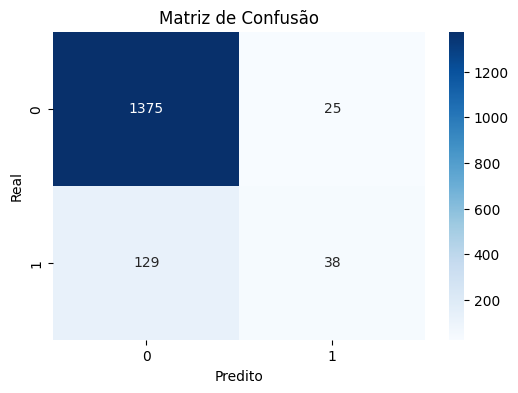

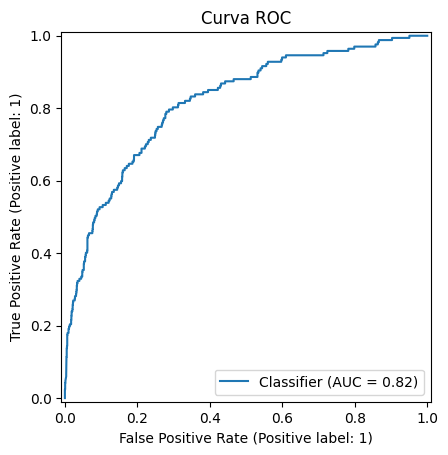

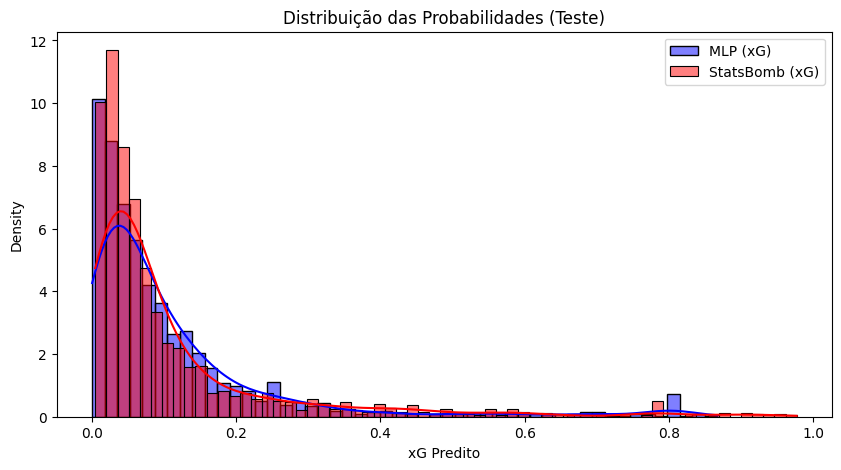

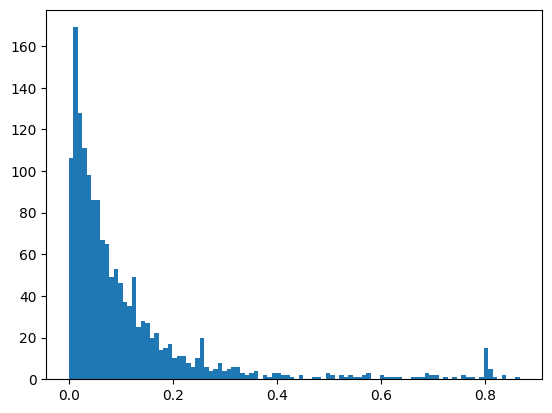

Min 6.606007214639639e-05
Max 0.8671591733896858
Mean 0.1099481084001937


In [ ]:
results(X_test_pca, mlp)

## 5 Componentes

In [ ]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.59      0.26      0.36       167

    accuracy                           0.90      1567
   macro avg       0.75      0.62      0.65      1567
weighted avg       0.88      0.90      0.88      1567


Brier Score:  0.0763


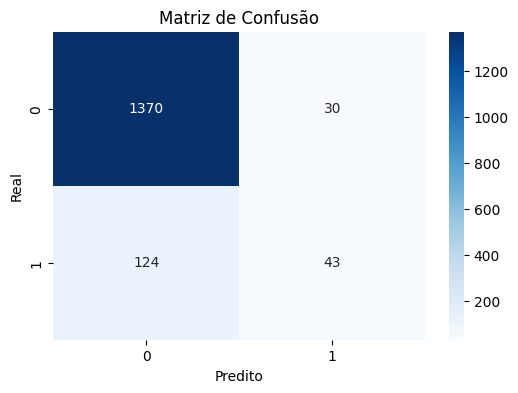

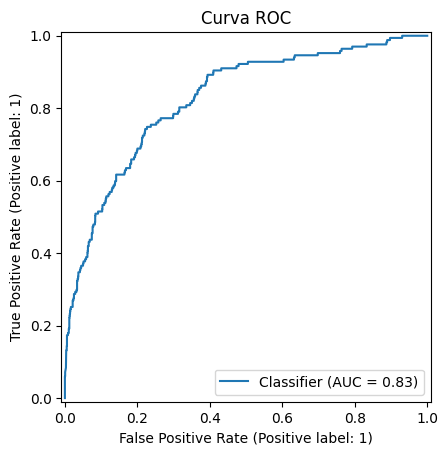

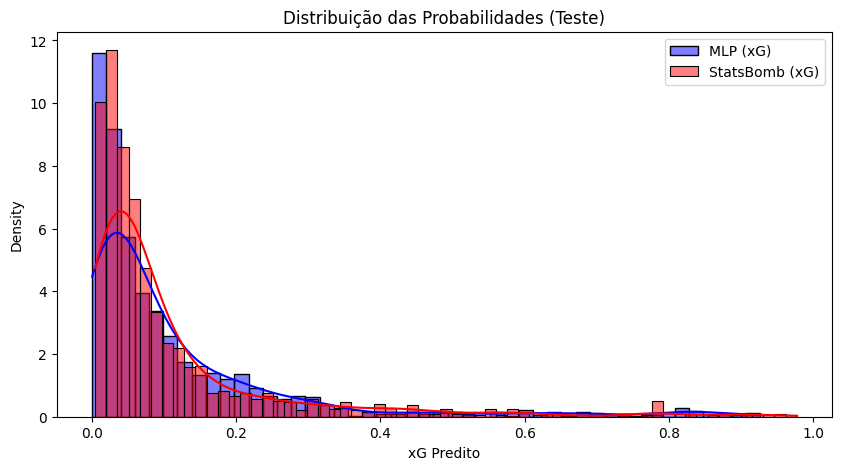

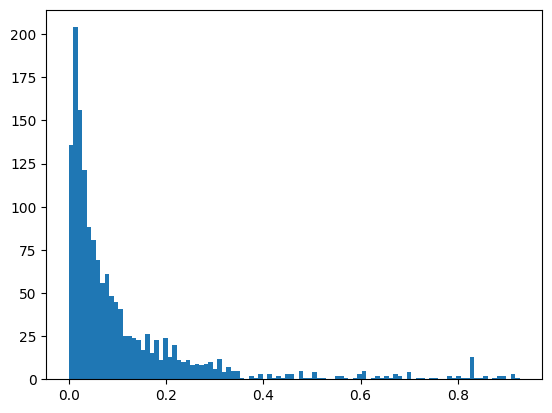

Min 0.00011993600140902766
Max 0.9268690367060373
Mean 0.11585451434963721


In [ ]:
results(X_test_pca, mlp)

## 7 Componentes

In [ ]:
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.61      0.27      0.37       167

    accuracy                           0.90      1567
   macro avg       0.76      0.62      0.66      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0762


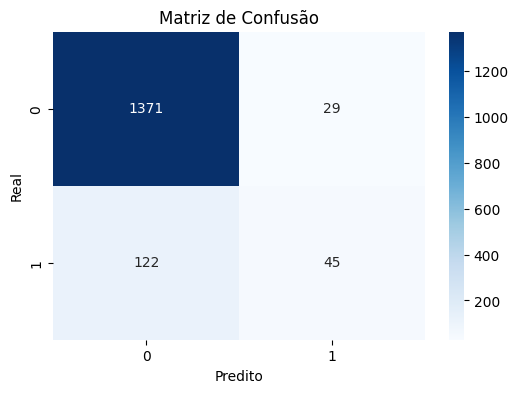

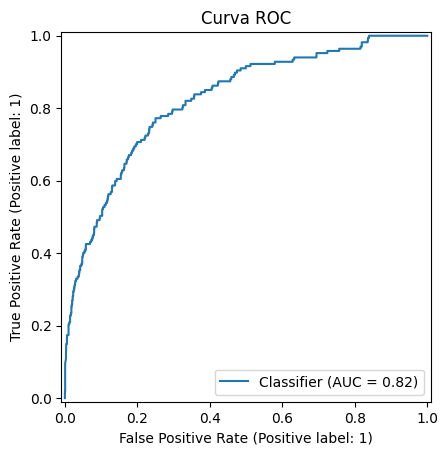

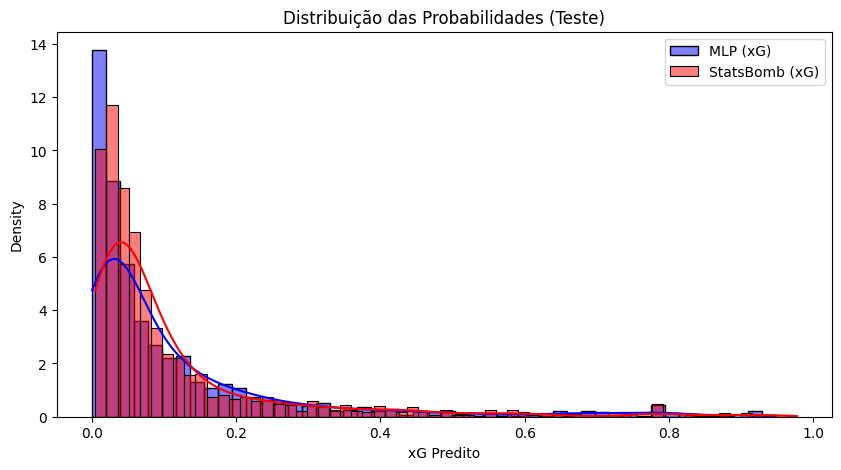

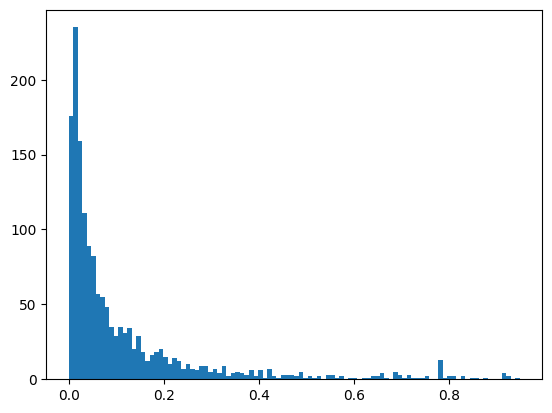

Min 7.459211903533577e-05
Max 0.9491120591561613
Mean 0.11505103648021396


In [ ]:
results(X_test_pca, mlp)

## 10 Componentes

In [ ]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.62      0.29      0.39       167

    accuracy                           0.91      1567
   macro avg       0.77      0.63      0.67      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0752


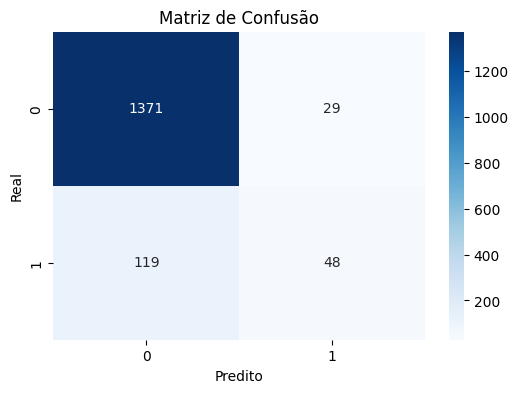

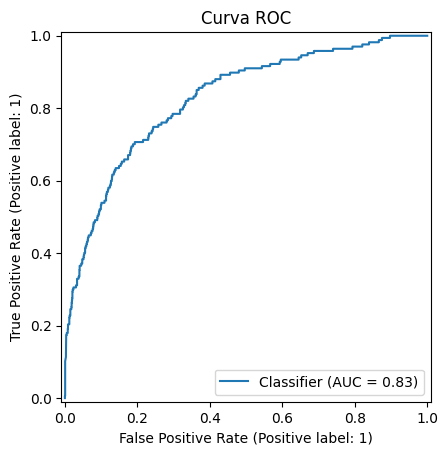

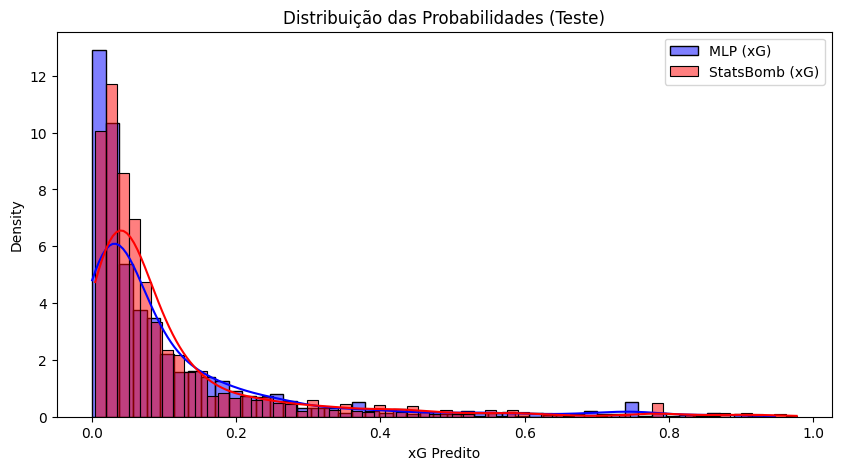

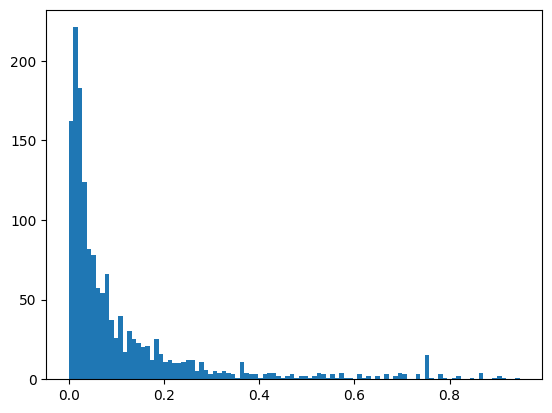

Min 9.536649018241534e-05
Max 0.9469207544909052
Mean 0.11283106485217796


In [ ]:
results(X_test_pca, mlp)

## 14 Componentes

In [ ]:
pca = PCA(n_components=14)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.59      0.29      0.39       167

    accuracy                           0.90      1567
   macro avg       0.75      0.63      0.67      1567
weighted avg       0.88      0.90      0.89      1567


Brier Score:  0.0773


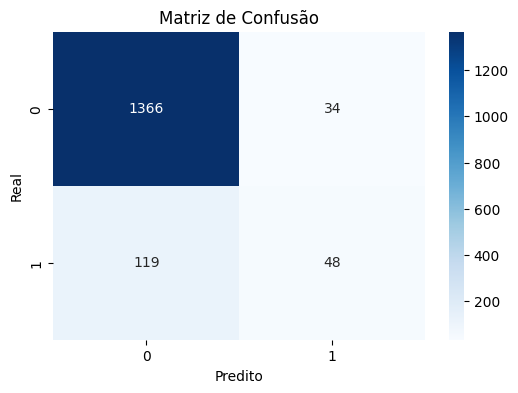

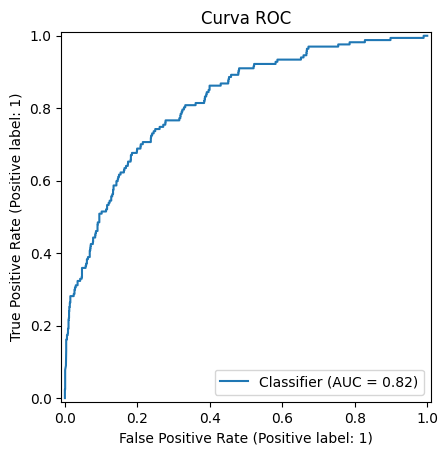

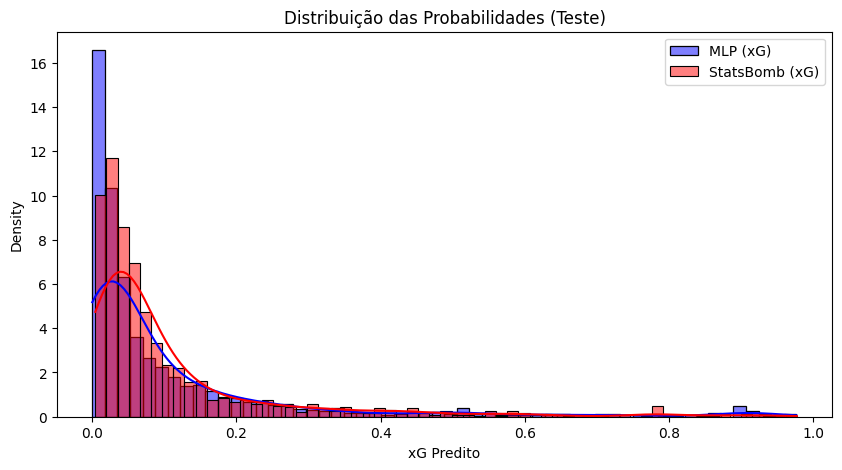

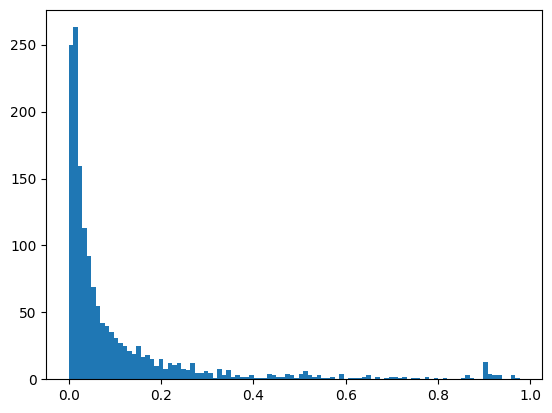

Min 0.00014603054181150645
Max 0.9766252642723336
Mean 0.10799010410248504


In [ ]:
results(X_test_pca, mlp)

## 17 Componentes

In [ ]:
pca = PCA(n_components=17)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.59      0.29      0.39       167

    accuracy                           0.90      1567
   macro avg       0.76      0.63      0.67      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0772


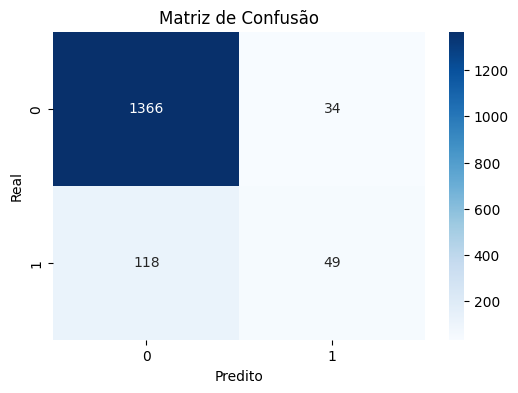

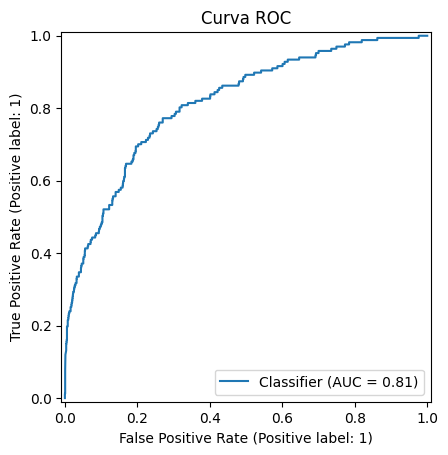

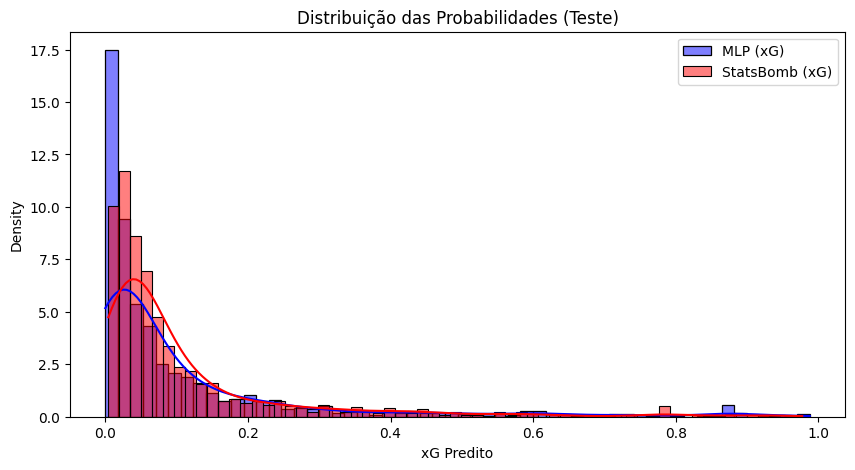

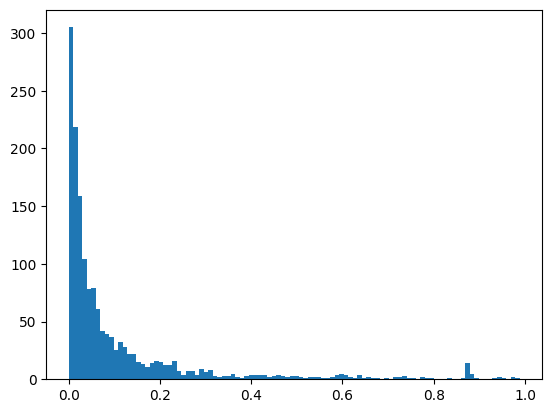

Min 9.62346478633531e-05
Max 0.9878446598349909
Mean 0.10896356927869819


In [ ]:
results(X_test_pca, mlp)

## 20 Componentes

In [ ]:
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.65      0.30      0.41       167

    accuracy                           0.91      1567
   macro avg       0.79      0.64      0.68      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0761


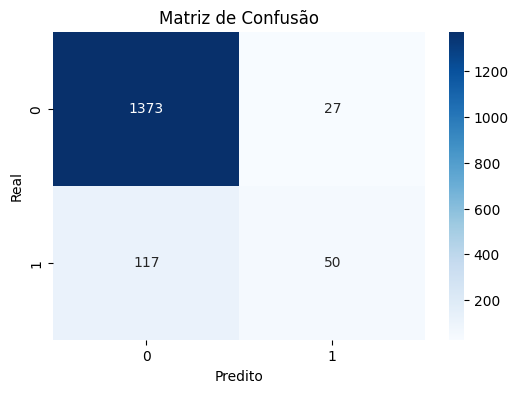

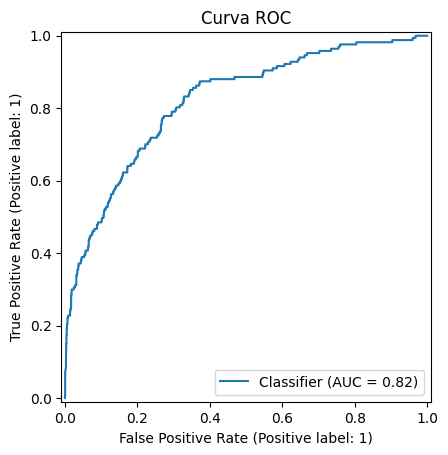

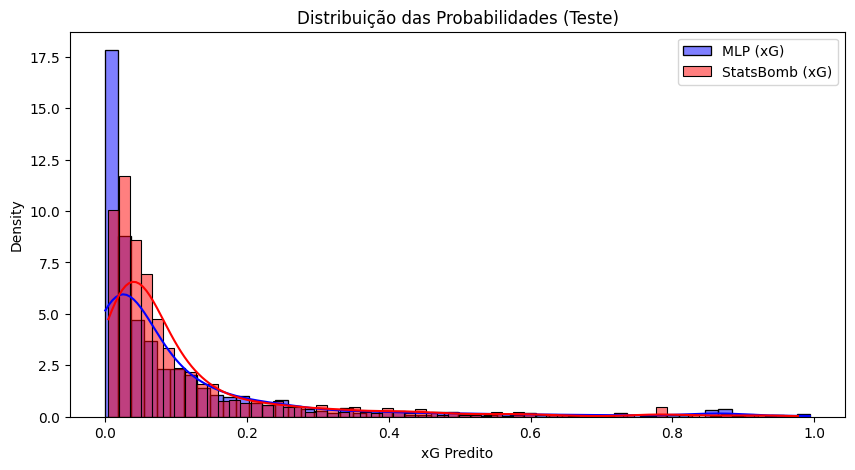

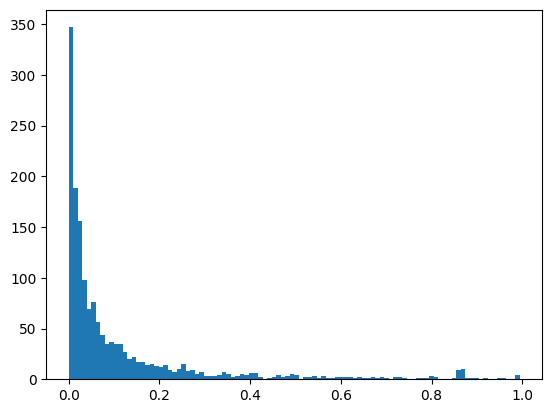

Min 4.912365307421535e-06
Max 0.9939833318452599
Mean 0.10902736476986238


In [ ]:
results(X_test_pca, mlp)

## 23 Componentes

In [ ]:
pca = PCA(n_components=23)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp = MLPClassifier()
mlp.fit(X_train_pca, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1400
           1       0.58      0.31      0.41       167

    accuracy                           0.90      1567
   macro avg       0.75      0.64      0.68      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0764


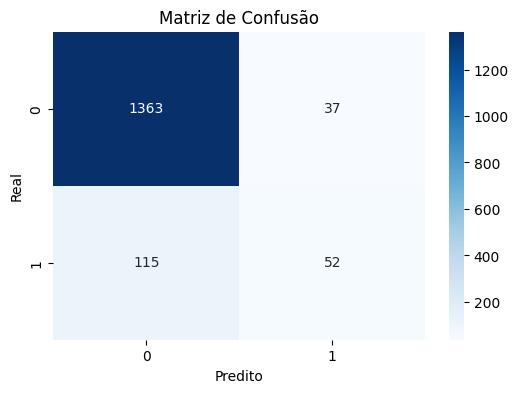

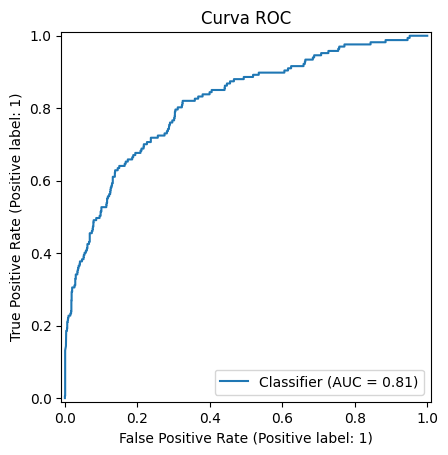

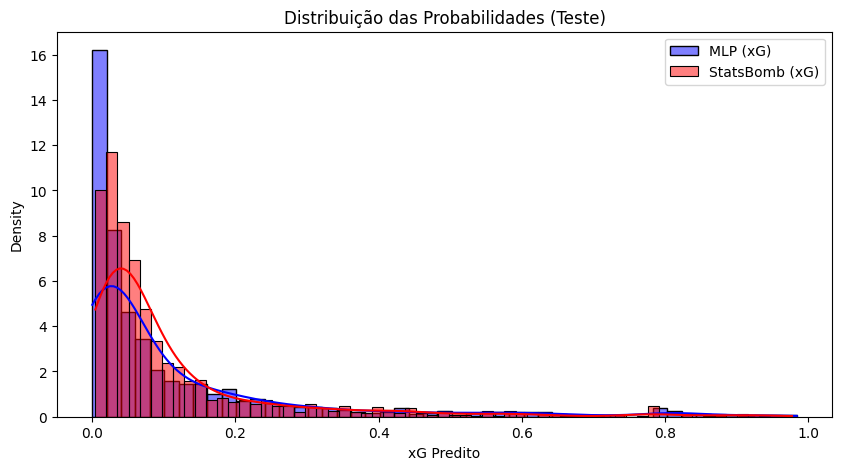

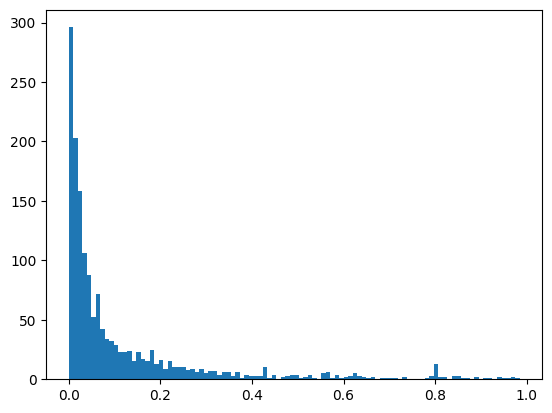

Min 5.941646819449409e-05
Max 0.9840335561812412
Mean 0.11674339205690477


In [ ]:
results(X_test_pca, mlp)

## Análise das métricas em relção ao PCA

In [ ]:
max_components = X_train_scaled.shape[1]

resultados = []

for n_components in range(1, max_components + 1):
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    mlp = MLPClassifier()
    mlp.fit(X_train_pca, y_train.values.ravel())

    y_pred = mlp.predict(X_test_pca)
    y_prob = mlp.predict_proba(X_test_pca)[:, 1]

    resultados.append({
        "n_components": n_components,
        "accuracy": accuracy_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob),
        "recall": recall_score(y_test, y_pred),
        "brier": brier_score_loss(y_test, y_prob)
    })

results_df = pd.DataFrame(resultados)
results_df.head()

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

,n_components,accuracy,roc_auc,recall,brier
0,1,0.893427,0.685597,0.000000,0.091233
1,2,0.899809,0.816354,0.215569,0.077015
2,3,0.900447,0.822675,0.239521,0.076908
3,4,0.902999,0.824001,0.245509,0.076015
4,5,0.902999,0.825122,0.257485,0.076278


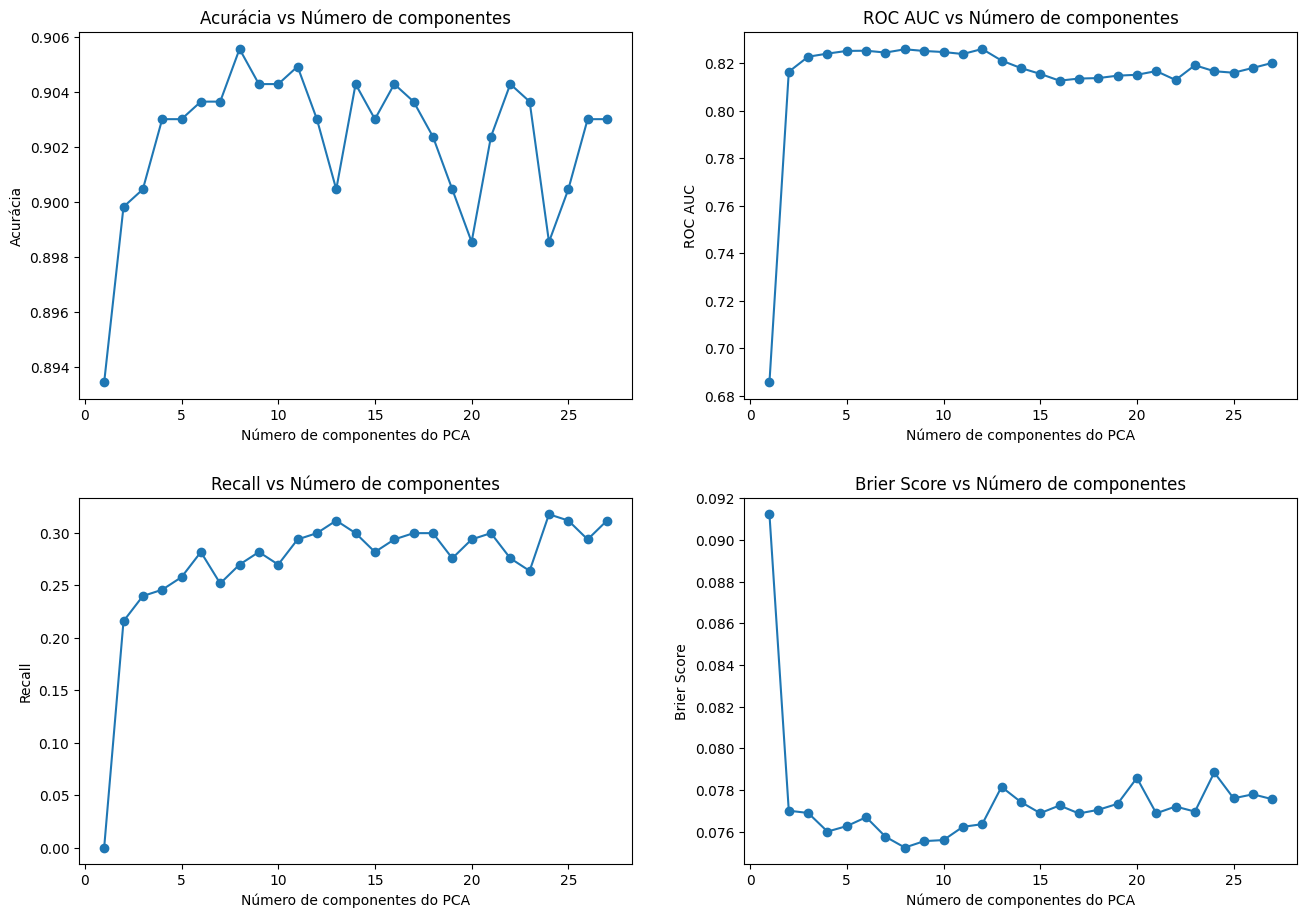

In [ ]:
results_df = pd.DataFrame(resultados, columns=["n_components", "accuracy", "roc_auc", "recall", "brier"])

# Criando uma grid de gráficos
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid para as 4 métricas
fig.tight_layout(pad=5.0)  # Ajuste do espaçamento

metrics = ["accuracy", "roc_auc", "recall", "brier"]
titles = ["Acurácia", "ROC AUC", "Recall", "Brier Score"]

for i, metric in enumerate(metrics):
    row = i // 2  # Calculando a linha (0 ou 1)
    col = i % 2   # Calculando a coluna (0 ou 1)

    axes[row, col].plot(results_df["n_components"], results_df[metric], marker='o')
    axes[row, col].set_xlabel("Número de componentes do PCA")
    axes[row, col].set_ylabel(titles[i])
    axes[row, col].set_title(f"{titles[i]} vs Número de componentes")

plt.show()

# Treinamento 3 - Otimização de Hiperparâmetros

## Maximizando Acurácia

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="maximize"
)

study.optimize(partial(objective, metric="accuracy", pca_method=False), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train, y_train)

[I 2025-12-13 17:50:17,969] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 17:50:23,389] Trial 0 finished with value: 0.9036375239310785 and parameters: {'num_layers': 3, 'layer_0_size': 408, 'layer_1_size': 65, 'layer_2_size': 140, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0006112663951025602, 'batch_size': 39, 'learning_rate_init': 0.006048143367033615, 'learning_rate': 'invscaling', 'max_iter': 315}. Best is trial 0 with value: 0.9036375239310785.
[I 2025-12-13 17:50:23,922] Trial 1 finished with value: 0.9029993618379069 and parameters: {'num_layers': 1, 'layer_0_size': 138, 'activation': 'logistic', 'solver': 'adam', 'alpha': 2.2020001316191887e-06, 'batch_size': 327, 'learning_rate_init': 0.005510492724740803, 'learning_rate': 'invscaling', 'max_iter': 747}. Best is trial 0 with value: 0.9036375239310785.
[I 2025-12-13 17:50:25,631] Trial 2 finished with value: 0.9036375239310785 and parameters: {'num_layers': 2, 'layer_0_size': 414, 'layer_1_

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.005956582238108924,
                               batch_size=255, early_stopping=True,
                               hidden_layer_sizes=(256,),
                               learning_rate_init=0.003095320166609615,
                               max_iter=471, random_state=42))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1400
           1       0.69      0.25      0.36       167

    accuracy                           0.91      1567
   macro avg       0.81      0.62      0.66      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0745


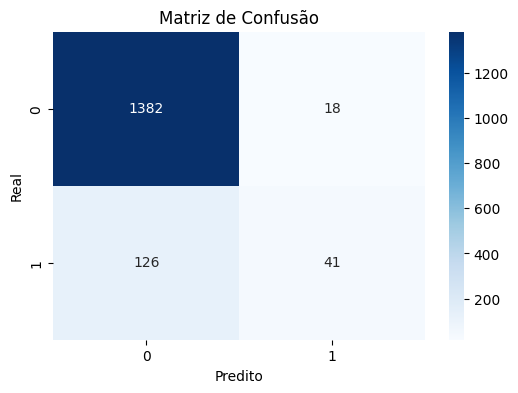

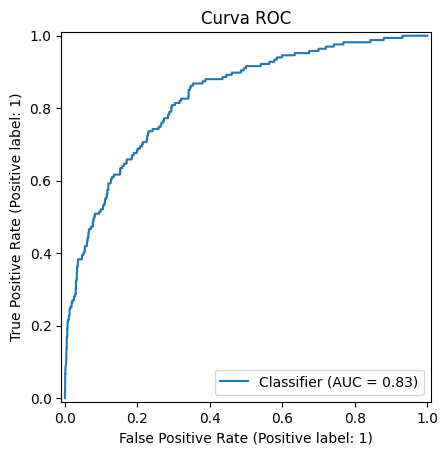

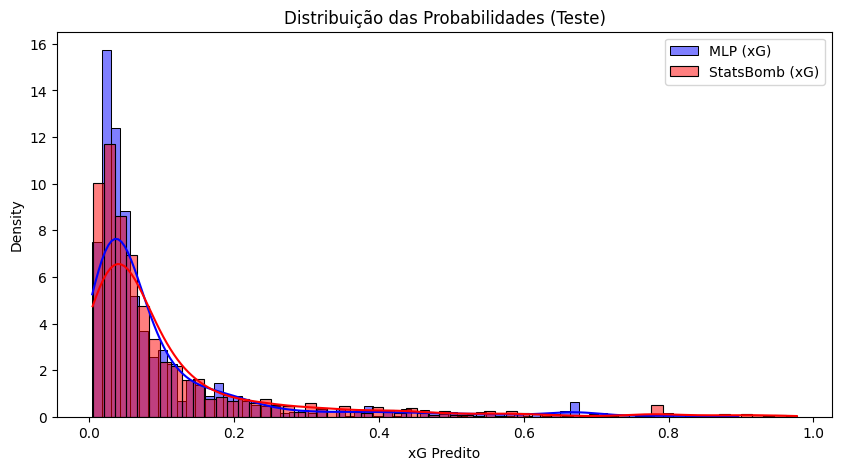

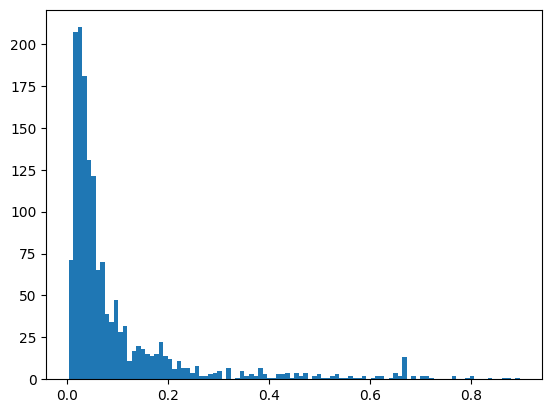

Min 0.0038476489877869112
Max 0.8965058683982738
Mean 0.09921066601928881


In [ ]:
results(X_test, pipeline)

## Maximizando Auc

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="maximize"
)

study.optimize(partial(objective, metric="auc", pca_method=False), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train, y_train)

[I 2025-12-13 17:57:02,880] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 17:57:12,573] Trial 0 finished with value: 0.8314905902480754 and parameters: {'num_layers': 4, 'layer_0_size': 329, 'layer_1_size': 290, 'layer_2_size': 153, 'layer_3_size': 84, 'activation': 'logistic', 'solver': 'adam', 'alpha': 2.670977024900541e-06, 'batch_size': 265, 'learning_rate_init': 0.0034313351136198655, 'learning_rate': 'constant', 'max_iter': 461}. Best is trial 0 with value: 0.8314905902480754.
[I 2025-12-13 17:57:28,029] Trial 1 finished with value: 0.8154811804961506 and parameters: {'num_layers': 3, 'layer_0_size': 292, 'layer_1_size': 143, 'layer_2_size': 196, 'activation': 'relu', 'solver': 'sgd', 'alpha': 1.068403015975934e-06, 'batch_size': 471, 'learning_rate_init': 0.03393964722136187, 'learning_rate': 'adaptive', 'max_iter': 331, 'momentum': 0.022995834758743835, 'nesterovs_momentum': False}. Best is trial 0 with value: 0.8314905902480754.
[I 2025-12-13 17:58:12,

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.00474884688983224,
                               batch_size=234, early_stopping=True,
                               hidden_layer_sizes=(348,),
                               learning_rate='adaptive',
                               learning_rate_init=0.001036585828070984,
                               max_iter=261, random_state=42))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.61      0.26      0.37       167

    accuracy                           0.90      1567
   macro avg       0.76      0.62      0.66      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0744


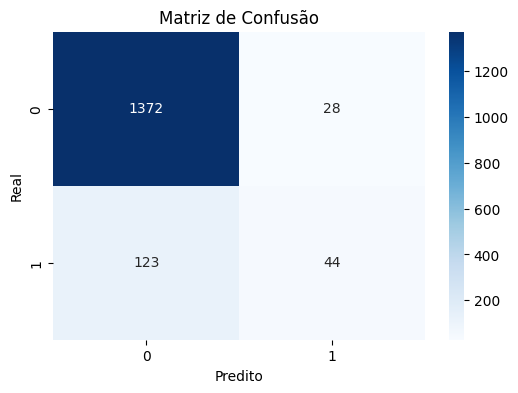

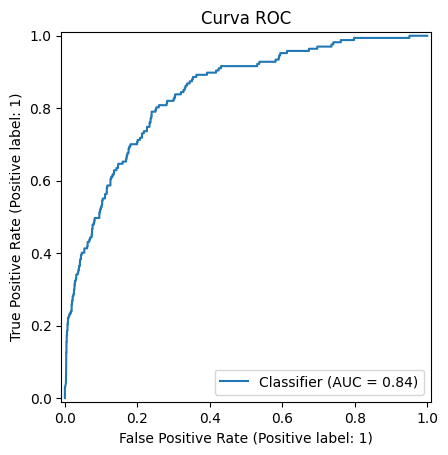

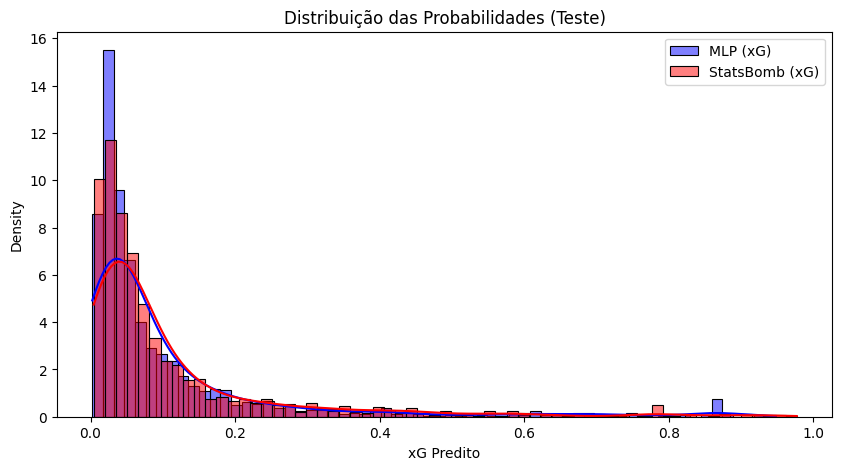

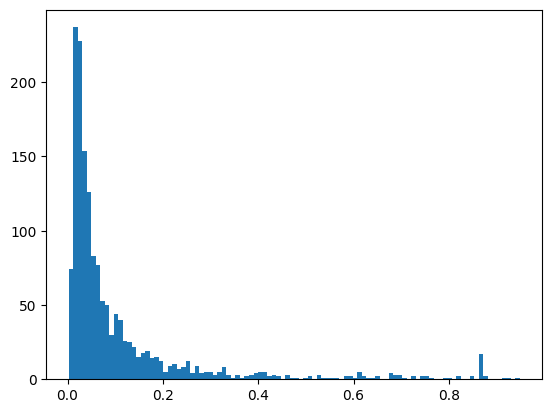

Min 0.0023809761792790746
Max 0.948208536407671
Mean 0.10753114356751643


In [ ]:
results(X_test, pipeline)

## Maximizando Recall

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="maximize"
)

study.optimize(partial(objective, metric="recall", pca_method=False), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train, y_train)

[I 2025-12-13 18:07:17,243] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 18:07:17,560] Trial 0 finished with value: 0.25149700598802394 and parameters: {'num_layers': 1, 'layer_0_size': 107, 'activation': 'relu', 'solver': 'adam', 'alpha': 4.752353333747212e-05, 'batch_size': 351, 'learning_rate_init': 0.001561513433305206, 'learning_rate': 'constant', 'max_iter': 243}. Best is trial 0 with value: 0.25149700598802394.
[I 2025-12-13 18:07:22,765] Trial 1 finished with value: 0.0 and parameters: {'num_layers': 4, 'layer_0_size': 198, 'layer_1_size': 334, 'layer_2_size': 299, 'layer_3_size': 165, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0015446816446818442, 'batch_size': 125, 'learning_rate_init': 0.004023719508496198, 'learning_rate': 'constant', 'max_iter': 865, 'momentum': 0.49442977870133814, 'nesterovs_momentum': True}. Best is trial 0 with value: 0.25149700598802394.
[I 2025-12-13 18:07:28,035] Trial 2 finished with value: 0.0 and parameters: {

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.0008792665944708883,
                               batch_size=334, early_stopping=True,
                               hidden_layer_sizes=(214,),
                               learning_rate_init=2.672466647706553e-05,
                               max_iter=263, random_state=42))])


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1400
           1       0.47      0.38      0.42       167

    accuracy                           0.89      1567
   macro avg       0.70      0.66      0.68      1567
weighted avg       0.88      0.89      0.88      1567


Brier Score:  0.1111


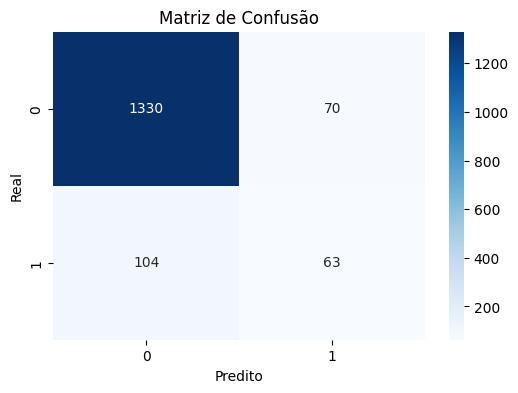

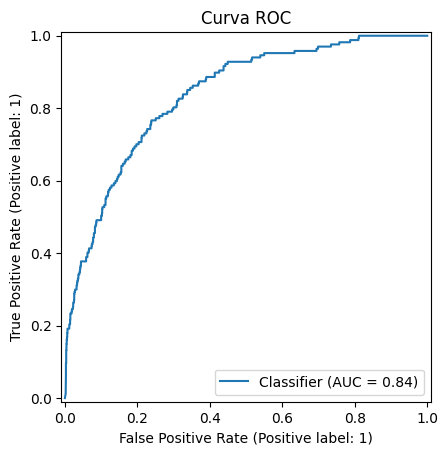

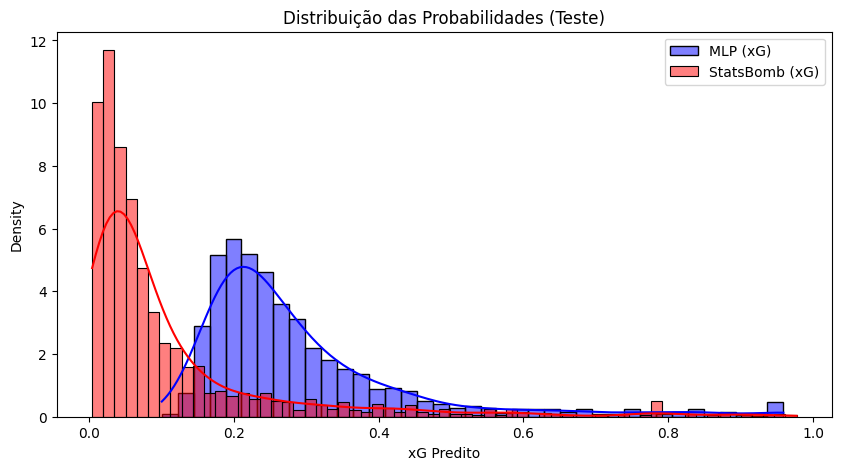

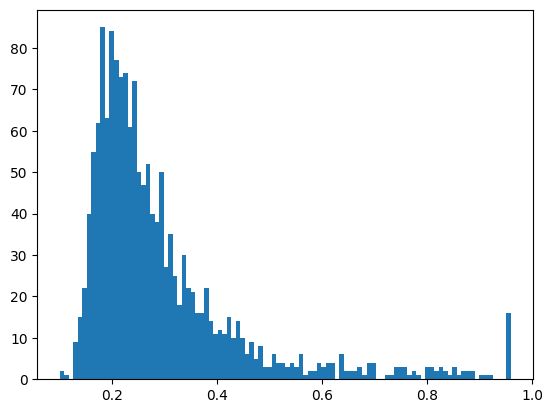

Min 0.10054749284040518
Max 0.9588639329542155
Mean 0.29404268574226566


In [ ]:
results(X_test, pipeline)

## Minimizando Brier Score

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="minimize"
)

study.optimize(partial(objective, metric="brier_score", pca_method=False), n_trials=100)

[I 2025-12-13 18:19:59,078] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 18:20:06,173] Trial 0 finished with value: 0.07479386537760153 and parameters: {'num_layers': 3, 'layer_0_size': 405, 'layer_1_size': 23, 'layer_2_size': 385, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00965365963944356, 'batch_size': 129, 'learning_rate_init': 0.009115315485492456, 'learning_rate': 'invscaling', 'max_iter': 231}. Best is trial 0 with value: 0.07479386537760153.
[I 2025-12-13 18:20:06,509] Trial 1 finished with value: 0.07590422124126738 and parameters: {'num_layers': 1, 'layer_0_size': 119, 'activation': 'relu', 'solver': 'adam', 'alpha': 8.069363829971101e-05, 'batch_size': 423, 'learning_rate_init': 0.030682822625008984, 'learning_rate': 'constant', 'max_iter': 999}. Best is trial 0 with value: 0.07479386537760153.
[I 2025-12-13 18:20:12,096] Trial 2 finished with value: 0.08591269392842589 and parameters: {'num_layers': 1, 'layer_0_size': 270, 'activation': 't

In [ ]:
best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.0006217197786025344,
                               batch_size=105, early_stopping=True,
                               hidden_layer_sizes=(511, 53),
                               learning_rate='adaptive',
                               learning_rate_init=0.0024176254620125247,
                               max_iter=413, random_state=42))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.63      0.26      0.37       167

    accuracy                           0.90      1567
   macro avg       0.77      0.62      0.66      1567
weighted avg       0.89      0.90      0.89      1567


Brier Score:  0.0742


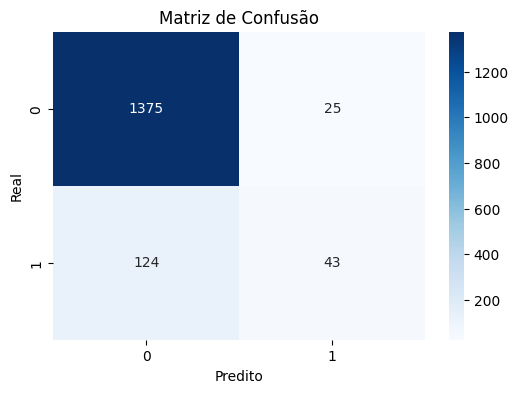

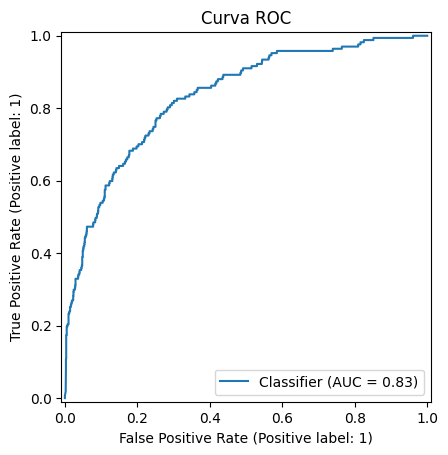

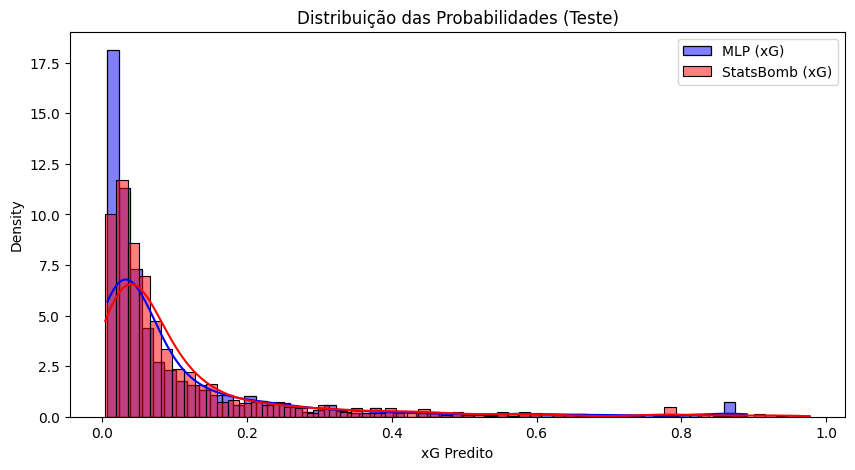

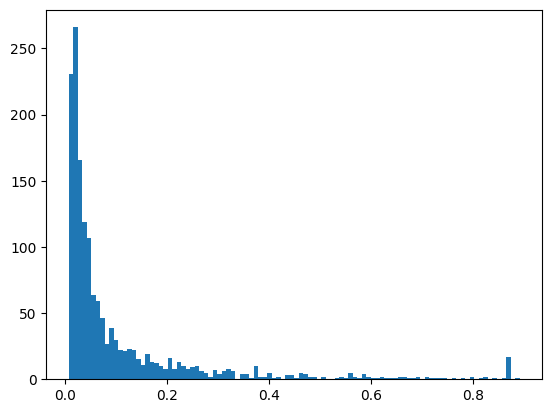

Min 0.0073402829085291305
Max 0.8903418790990697
Mean 0.10682053502756907


In [ ]:
results(X_test, pipeline)

# Treinamento 4 - Otimização de Hiperparâmetros + PCA

## Maximizando Acurácia

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="maximize"
)

study.optimize(partial(objective, metric="accuracy", pca_method=True), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 18:31:26,052] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 18:31:33,158] Trial 0 finished with value: 0.9017230376515635 and parameters: {'num_layers': 3, 'layer_0_size': 150, 'layer_1_size': 269, 'layer_2_size': 103, 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.0756969967332984e-05, 'batch_size': 95, 'learning_rate_init': 0.001726097120304236, 'learning_rate': 'constant', 'max_iter': 857, 'n_components': 15}. Best is trial 0 with value: 0.9017230376515635.
[I 2025-12-13 18:31:33,750] Trial 1 finished with value: 0.8934269304403318 and parameters: {'num_layers': 2, 'layer_0_size': 114, 'layer_1_size': 25, 'activation': 'logistic', 'solver': 'adam', 'alpha': 3.014942585594288e-06, 'batch_size': 242, 'learning_rate_init': 7.848847457697785e-05, 'learning_rate': 'constant', 'max_iter': 405, 'n_components': 21}. Best is trial 0 with value: 0.9017230376515635.
[I 2025-12-13 18:31:37,584] Trial 2 finished with value: 0.9042756860242501 and pa

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.008729533378071901,
                               batch_size=101, early_stopping=True,
                               hidden_layer_sizes=(98, 207),
                               learning_rate_init=0.0005950343511135452,
                               max_iter=582, random_state=42))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1400
           1       0.74      0.23      0.35       167

    accuracy                           0.91      1567
   macro avg       0.83      0.61      0.65      1567
weighted avg       0.90      0.91      0.89      1567


Brier Score:  0.075


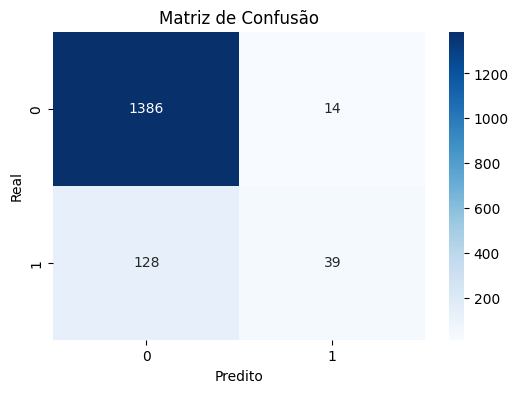

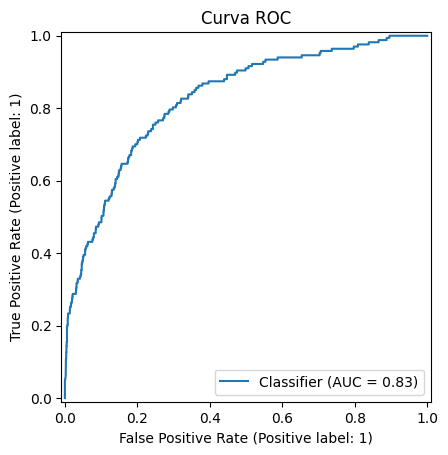

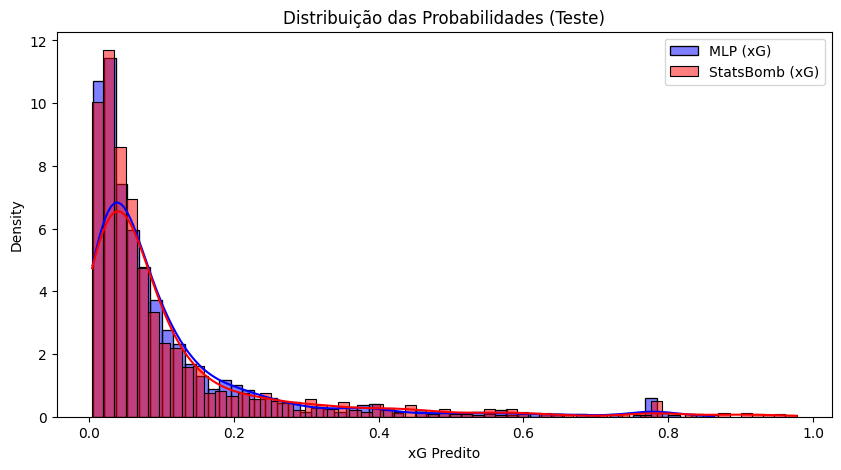

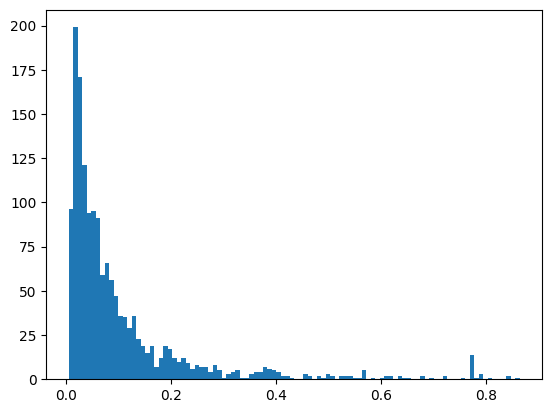

Min 0.005086898757857012
Max 0.8631534668755664
Mean 0.10597911286255345


In [ ]:
results(X_test_pca, pipeline)

## Maximizando Auc

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="maximize"
)

study.optimize(partial(objective, metric="auc", pca_method=True), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 18:38:04,319] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 18:38:07,197] Trial 0 finished with value: 0.7033126603934986 and parameters: {'num_layers': 2, 'layer_0_size': 406, 'layer_1_size': 311, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0002737233409782995, 'batch_size': 191, 'learning_rate_init': 0.07597317289110196, 'learning_rate': 'constant', 'max_iter': 280, 'momentum': 0.680180200197419, 'nesterovs_momentum': False, 'n_components': 27}. Best is trial 0 with value: 0.7033126603934986.
[I 2025-12-13 18:38:08,515] Trial 1 finished with value: 0.5840825491873396 and parameters: {'num_layers': 2, 'layer_0_size': 61, 'layer_1_size': 485, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.0012342213624718646, 'batch_size': 389, 'learning_rate_init': 0.023862188269198156, 'learning_rate': 'constant', 'max_iter': 618, 'momentum': 0.7860774583033429, 'nesterovs_momentum': False, 'n_components': 22}. Best is trial 0 with value: 0.7033

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='logistic',
                               alpha=0.0007213435382299601, batch_size=291,
                               early_stopping=True, hidden_layer_sizes=(115,),
                               learning_rate='adaptive',
                               learning_rate_init=0.04252372593916189,
                               max_iter=283, random_state=42, solver='sgd'))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1400
           1       0.59      0.28      0.38       167

    accuracy                           0.90      1567
   macro avg       0.75      0.63      0.66      1567
weighted avg       0.88      0.90      0.89      1567


Brier Score:  0.0754


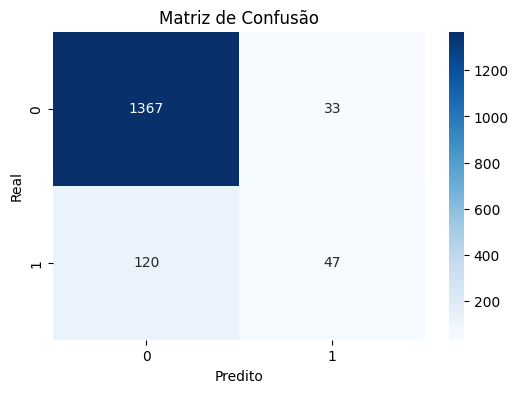

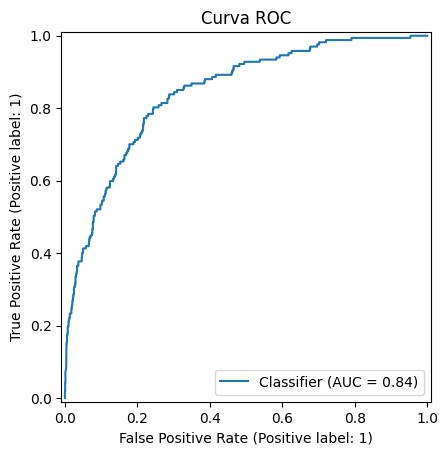

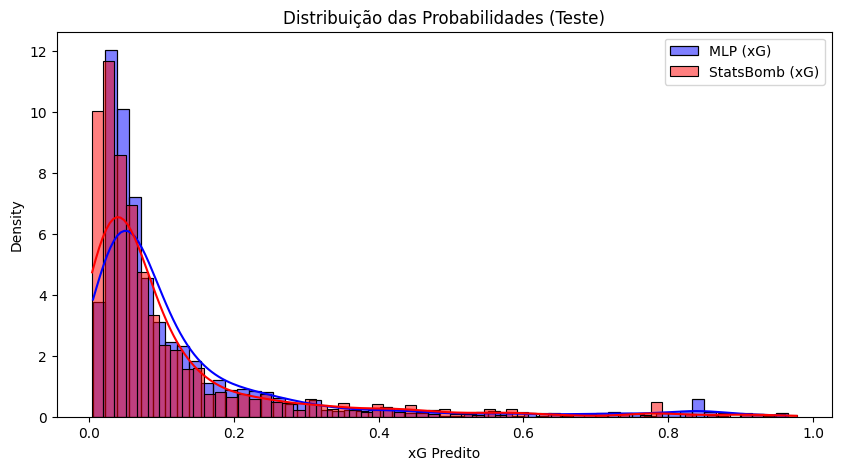

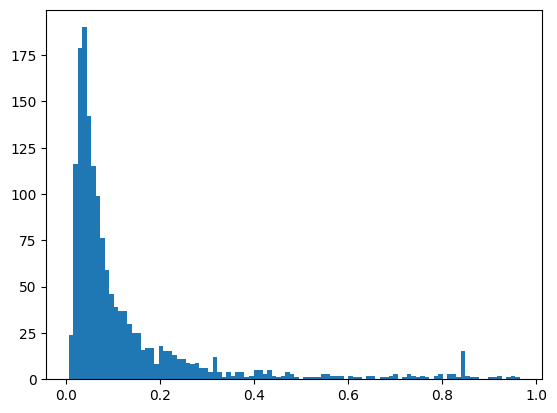

Min 0.005583538508686258
Max 0.964615028396639
Mean 0.12820285165846224


In [ ]:
results(X_test_pca, pipeline)

## Maximizando Recall

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="maximize"
)

study.optimize(partial(objective, metric="recall", pca_method=True), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 18:46:36,340] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 18:46:42,715] Trial 0 finished with value: 0.31137724550898205 and parameters: {'num_layers': 3, 'layer_0_size': 267, 'layer_1_size': 506, 'layer_2_size': 221, 'activation': 'tanh', 'solver': 'adam', 'alpha': 4.189856122303961e-06, 'batch_size': 291, 'learning_rate_init': 0.0005241317331193003, 'learning_rate': 'constant', 'max_iter': 213, 'n_components': 18}. Best is trial 0 with value: 0.31137724550898205.
[I 2025-12-13 18:46:46,140] Trial 1 finished with value: 0.17365269461077845 and parameters: {'num_layers': 3, 'layer_0_size': 247, 'layer_1_size': 57, 'layer_2_size': 73, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0030037697208187305, 'batch_size': 42, 'learning_rate_init': 2.2660994323027997e-05, 'learning_rate': 'adaptive', 'max_iter': 763, 'n_components': 8}. Best is trial 0 with value: 0.31137724550898205.
[I 2025-12-13 18:46:50,921] Trial 2 finished with value: 0.0 and p

In [ ]:
results(X_test_pca, pipeline)

## Minimizando Brier Score

In [ ]:
study = optuna.create_study(
    study_name="MLP_xG_optimize",
    direction="minimize"
)

study.optimize(partial(objective, metric="brier_score", pca_method=True), n_trials=100)

best_params = study.best_trial.params

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=best_params["n_components"])
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train_pca, y_train)

[I 2025-12-13 23:39:26,383] A new study created in memory with name: MLP_xG_optimize
[I 2025-12-13 23:39:30,317] Trial 0 finished with value: 0.07722587907670737 and parameters: {'num_layers': 1, 'layer_0_size': 378, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.000872286139804096, 'batch_size': 61, 'learning_rate_init': 0.00715840559254421, 'learning_rate': 'adaptive', 'max_iter': 713, 'n_components': 10}. Best is trial 0 with value: 0.07722587907670737.
[I 2025-12-13 23:39:40,545] Trial 1 finished with value: 0.07492929413733619 and parameters: {'num_layers': 2, 'layer_0_size': 354, 'layer_1_size': 261, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010658627210751188, 'batch_size': 471, 'learning_rate_init': 0.0019551110864035426, 'learning_rate': 'constant', 'max_iter': 239, 'n_components': 25}. Best is trial 1 with value: 0.07492929413733619.
[I 2025-12-13 23:39:51,218] Trial 2 finished with value: 0.10518461760874985 and parameters: {'num_layers': 4, 'layer_0_size'

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=4.342304114176999e-05,
                               batch_size=385, early_stopping=True,
                               hidden_layer_sizes=(220, 290),
                               learning_rate_init=0.09576416146990077,
                               max_iter=544, random_state=42, solver='sgd'))])


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1400
           1       0.68      0.24      0.35       167

    accuracy                           0.91      1567
   macro avg       0.80      0.61      0.65      1567
weighted avg       0.89      0.91      0.89      1567


Brier Score:  0.0742


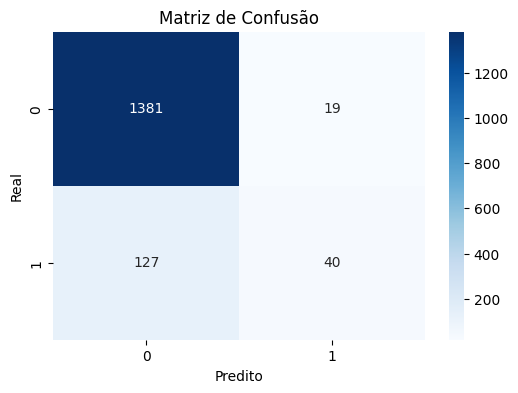

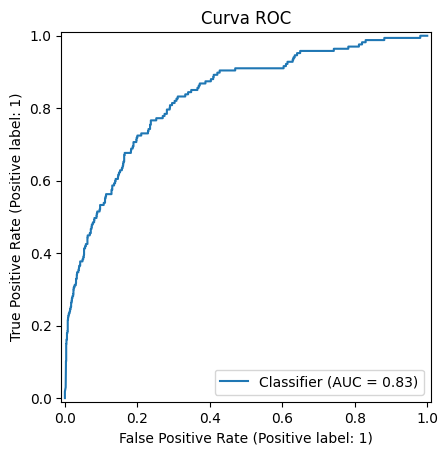

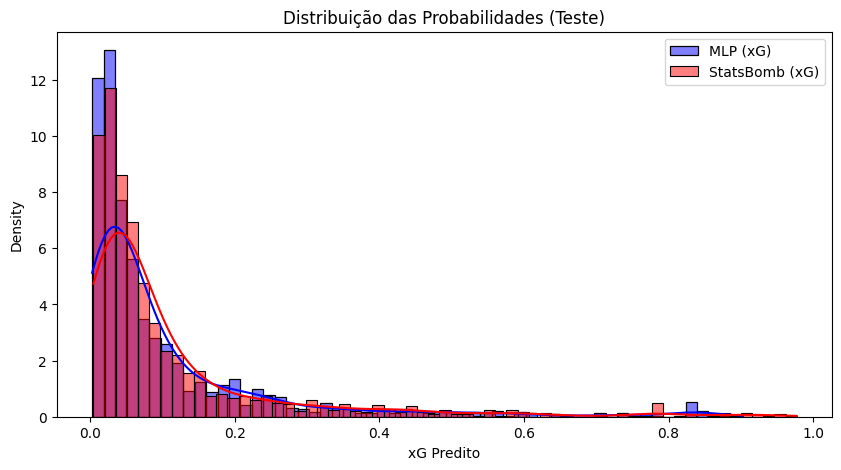

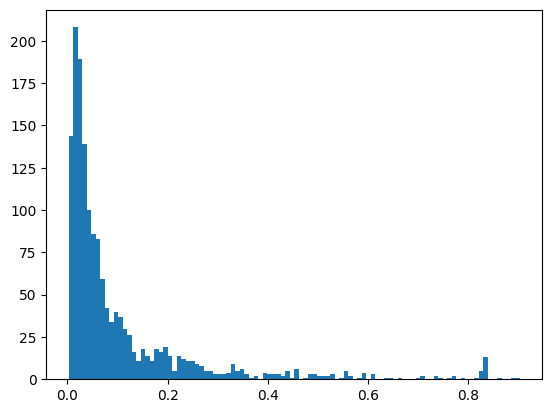

Min 0.0025767097041443617
Max 0.9023854730916119
Mean 0.10547231745508176


In [ ]:
results(X_test_pca, pipeline)

# Treinando 30 vezes

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=17)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

mlp_params = {
    'hidden_layer_sizes': (220, 290),
    'activation': 'tanh',
    'solver': 'sgd',
    'alpha': 4.342304114176999e-05,
    'batch_size': 385,
    'learning_rate_init': 0.09576416146990077,
    'learning_rate': 'constant',
    'max_iter': 544,
    'momentum': 0.7880473980158056,
    'nesterovs_momentum': False
}

results = run_mlp_multiple_times(
    X_train_pca, y_train.values.ravel(),
    X_test_pca, y_test.values.ravel(),
    mlp_params,
    n_runs=30
)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (544) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (544) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (544) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (544) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
print("Brier Score:",
      results["brier"].mean(), "±", results["brier"].std())

print("Accuracy:",
      results["accuracy"].mean(), "±", results["accuracy"].std())

print("AUC:",
      results["auc"].mean(), "±", results["auc"].std())


Brier Score: 0.10570176899688276 ± 0.01344425483998593
Accuracy: 0.8750478621569878 ± 0.013391676051171657
AUC: 0.7673152266894782 ± 0.026758456988952656


In [ ]:
results

{'all_probs': array([[2.50510565e-05, 7.06512393e-03, 4.20302652e-04, ...,
         5.92896100e-09, 1.14304651e-02, 2.13406034e-03],
        [1.83366417e-06, 2.10107070e-03, 2.79653029e-03, ...,
         4.41815014e-11, 1.23288981e-04, 1.76296224e-02],
        [1.22319917e-05, 9.50654476e-04, 2.09210608e-04, ...,
         6.88270006e-06, 2.83435057e-03, 1.80966902e-05],
        ...,
        [1.12744387e-02, 1.54989952e-02, 2.41559068e-01, ...,
         1.98442633e-02, 9.85562013e-02, 9.74680958e-02],
        [9.73928146e-07, 1.36373467e-03, 1.07677839e-03, ...,
         4.25857431e-08, 2.18039844e-02, 4.00286592e-05],
        [3.01820527e-04, 7.06746284e-05, 1.46609590e-02, ...,
         2.62502655e-05, 3.96086665e-03, 1.28218240e-05]]),
 'brier': array([0.10678496, 0.11086603, 0.11152942, 0.11057666, 0.11667918,
        0.11519232, 0.1125106 , 0.10988949, 0.10917967, 0.07599297,
        0.07686034, 0.12060439, 0.11136879, 0.0786707 , 0.10400181,
        0.11580743, 0.10692448, 0.11212

In [ ]:
mean_prob_per_instance = results["all_probs"].mean(axis=0)
std_prob_per_instance  = results["all_probs"].std(axis=0)


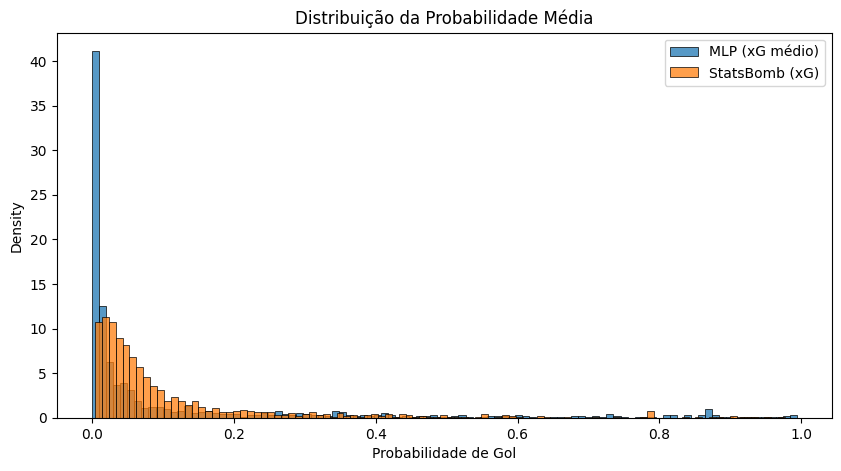

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(mean_prob_per_instance, bins=100, stat="density", label="MLP (xG médio)")
sns.histplot(xg_baseline,color='red', bins=100, stat="density", label="StatsBomb (xG)")
plt.legend()
plt.xlabel("Probabilidade de Gol")
plt.title("Distribuição da Probabilidade Média")
plt.show()

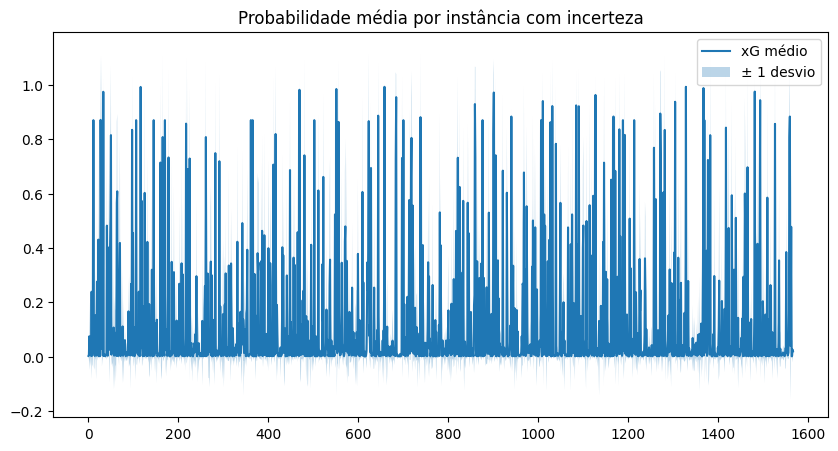

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(mean_prob_per_instance, label="xG médio")
plt.fill_between(
    range(len(mean_prob_per_instance)),
    mean_prob_per_instance - std_prob_per_instance,
    mean_prob_per_instance + std_prob_per_instance,
    alpha=0.3,
    label="± 1 desvio"
)
plt.legend()
plt.title("Probabilidade média por instância com incerteza")
plt.show()


# Treinamentos Extras

In [ ]:
best_params = {'num_layers': 1, 'layer_0_size': 211, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0003391988727757126, 'batch_size': 188, 'learning_rate_init': 0.00023981615408516247, 'learning_rate': 'invscaling', 'max_iter': 354, 'momentum': 0.11550204829642292, 'nesterovs_momentum': True}

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train, y_train)

In [ ]:
results(X_test, pipeline)

In [ ]:
best_params = {'num_layers': 1, 'layer_0_size': 195, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0005418961750338878, 'batch_size': 282, 'learning_rate_init': 2.231965735443866e-05, 'learning_rate': 'invscaling', 'max_iter': 340, 'momentum': 0.13971976563900562, 'nesterovs_momentum': True}

# Reconstruir os layers
layers = tuple([
    best_params[f"layer_{i}_size"]
    for i in range(best_params["num_layers"])
])

final_model = MLPClassifier(
    hidden_layer_sizes=layers,
    activation=best_params["activation"],
    solver=best_params["solver"],
    alpha=best_params["alpha"],
    batch_size=best_params["batch_size"],
    learning_rate_init=best_params["learning_rate_init"],
    learning_rate=best_params["learning_rate"],
    max_iter=best_params["max_iter"],
    random_state=42,
    early_stopping=True
)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", final_model)
])

pipeline.fit(X_train, y_train)

In [ ]:
results(X_test, pipeline)